In [52]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import os
import pandas as pd

import datetime
import time
from yahoo_historical import Fetcher



os.chdir(r'C:\Users\hadit\OneDrive - Prophix Software, Inc\AutoTrading')

 
# load dataset
ticker = 'ETH-CAD'
#dstart = '1-1-2021' #start date of data to calculate rolling averages
actual_start = '1-1-2022' # actual start date where data is analyzed

#dstart = datetime.datetime.strptime(actual_start, '%m-%d-%Y') -datetime.timedelta(days = 50) 
dstart = datetime.datetime.strptime(actual_start, '%m-%d-%Y')
print(dstart)
dstart = time.mktime(dstart.timetuple())
df = Fetcher(ticker, dstart).get_historical()
df.Date = pd.to_datetime(df.Date)
dates = df.Date

df.columns



2022-01-01 00:00:00


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [53]:
df['close_50'] = df.Close.ewm(span=50,adjust=False).mean()
df['close_12'] = df.Close.ewm(span=12,adjust=False).mean()

In [54]:
samp = df[df.Date>=pd.to_datetime('2022-9-1')]

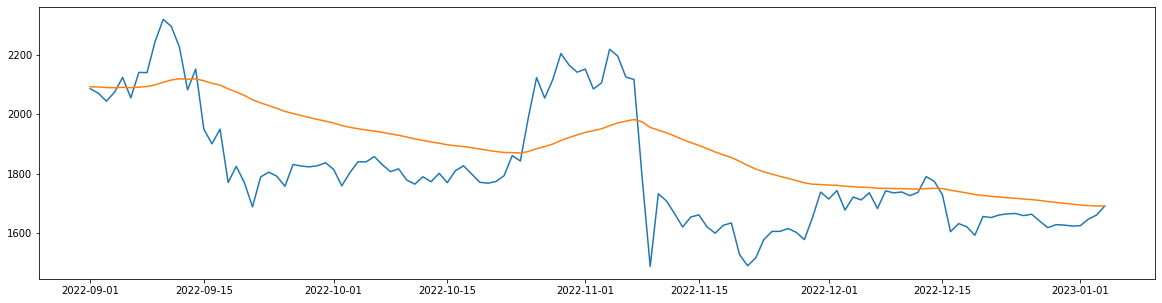

In [55]:
pyplot.figure(figsize=(20,5))
pyplot.plot(samp.Date, samp.Close)
pyplot.plot(samp.Date, samp.close_50)

In [56]:
y = df.Close.shift(-1) - df.Close
y = y>0
y  = y.astype(int)
df['y'] = y

N = df.shape[1]


In [57]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,close_50,close_12,y
359,2022-12-26,1658.957642,1663.715820,1650.539917,1663.715820,1663.715820,4450361325,1712.827469,1665.243917,0
360,2022-12-27,1663.733154,1668.880005,1627.873413,1640.312866,1640.312866,5533836237,1709.983759,1661.408370,0
361,2022-12-28,1640.238403,1641.254272,1613.023315,1618.496460,1618.496460,6789154890,1706.396021,1654.806538,1
362,2022-12-29,1618.529297,1631.660034,1615.487915,1628.673584,1628.673584,5600937320,1703.348083,1650.786084,0
363,2022-12-30,1628.638672,1629.492676,1608.004761,1627.291748,1627.291748,5503314701,1700.365481,1647.171570,0
364,2022-12-31,1627.464478,1635.245117,1620.474731,1623.958740,1623.958740,4095971667,1697.369139,1643.600366,1
365,2023-01-01,1623.880615,1631.383057,1618.685913,1625.373779,1625.373779,3247695539,1694.545791,1640.796275,1
366,2023-01-02,1625.561157,1656.265747,1616.793701,1647.529907,1647.529907,5107780682,1692.702031,1641.832219,1
367,2023-01-03,1647.648438,1653.166504,1652.023560,1660.974365,1660.974365,4639231152,1691.457809,1644.777164,1
368,2023-01-04,1660.561279,1695.758789,1657.093994,1691.497070,1691.497070,7451783680,1691.459348,1651.964842,0


In [58]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,close_50,close_12,y
0,2022-01-01,4655.555664,4765.364746,4654.594238,4765.085449,4765.085449,12357594823,4765.085449,4765.085449,1
1,2022-01-02,4764.581543,4842.118652,4711.566406,4848.099121,4848.099121,12509607009,4768.340887,4777.856783,0
2,2022-01-03,4848.062012,4888.744141,4717.070801,4796.455566,4796.455566,15405226757,4769.443424,4780.718134,1
3,2022-01-04,4796.431641,4927.568359,4744.676270,4820.447754,4820.447754,17826656266,4771.443593,4786.830384,0
4,2022-01-05,4820.717773,4883.027344,4409.953125,4530.520996,4530.520996,23047423854,4761.995648,4747.398170,0


In [59]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,close_50,close_12,y
364,2022-12-31,1627.464478,1635.245117,1620.474731,1623.958740,1623.958740,4095971667,1697.369139,1643.600366,1
365,2023-01-01,1623.880615,1631.383057,1618.685913,1625.373779,1625.373779,3247695539,1694.545791,1640.796275,1
366,2023-01-02,1625.561157,1656.265747,1616.793701,1647.529907,1647.529907,5107780682,1692.702031,1641.832219,1
367,2023-01-03,1647.648438,1653.166504,1652.023560,1660.974365,1660.974365,4639231152,1691.457809,1644.777164,1
368,2023-01-04,1660.561279,1695.758789,1657.093994,1691.497070,1691.497070,7451783680,1691.459348,1651.964842,0


In [60]:
df.drop(['Date','Adj Close'], axis=1, inplace=True)


In [61]:
df.head()

,Open,High,Low,Close,Volume,close_50,close_12,y
0,4655.555664,4765.364746,4654.594238,4765.085449,12357594823,4765.085449,4765.085449,1
1,4764.581543,4842.118652,4711.566406,4848.099121,12509607009,4768.340887,4777.856783,0
2,4848.062012,4888.744141,4717.070801,4796.455566,15405226757,4769.443424,4780.718134,1
3,4796.431641,4927.568359,4744.676270,4820.447754,17826656266,4771.443593,4786.830384,0
4,4820.717773,4883.027344,4409.953125,4530.520996,23047423854,4761.995648,4747.398170,0


In [62]:
# split into train and test sets
values = df.values
#n_train_hours = 365 * 24
train = values[:round(0.8*values.shape[0]), :]
test = values[round(0.8*values.shape[0]):, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]


print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(295, 7) (295,) (74, 7) (74,)


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
acc_base_logreg = accuracy_score(test_y, y_pred)
acc_base_logreg

0.5

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV


# Number of trees in random forest
import numpy as np
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(train_X, train_y)
rf_random.best_params_

y_pred = rf_random.predict(test_X)

acc_tuned = accuracy_score(y_pred, test_y)

rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(train_X, train_y)
y_pred = rf.predict(test_X)
acc_base = accuracy_score(test_y, y_pred)


from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
acc_xgb = accuracy_score(test_y, y_pred)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [65]:
acc_tuned

0.5135135135135135

In [66]:
acc_base

0.43243243243243246

In [67]:
acc_xgb

0.5

In [21]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

In [22]:
from mango import Tuner, scheduler


In [23]:
param_space = dict(n_estimators=n_estimators,
                   max_features = max_features,
                   max_depth = max_depth
                   )
